# **Khởi tạo**

**Import thư viện**

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_absolute_error
import os

**Xử lý dữ liệu**

In [9]:
def read_file(file_name):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_name)

    # Chuyển cột 'Date' thành kiểu dữ liệu datetime và đặt làm index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Chuyển đổi các cột khác sang dạng số nếu cần thiết
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    # Tiền xử lý các cột khác nếu cần thiết

    # Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
    data.sort_index(inplace=True)
    data = data.reset_index()['Price']

    return data

**Xây dựng mô hình**

In [10]:
# Hàm tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
# Hàm Create Dataset
def create_dataset(dataset, seq_size=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        dataX.append(window)
        dataY.append(dataset[i + seq_size, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
def GRU_prediction(name, file_name, train_ratio=0.7, test_ratio=0.2, forecast_days=30):
    # Đọc dữ liệu từ file CSV
    data = read_file(file_name)

    # Scaler data
    scaler = MinMaxScaler(feature_range=(0,1))
    data = scaler.fit_transform(np.array(data).reshape(-1,1))

    # Chia train, test
    train_size = int(train_ratio * len(data))
    test_size = int(test_ratio * len(data))
    train_data = data[:train_size]
    test_data = data[train_size:train_size+test_size]

    # Hàm Create Dataset
    def create_dataset(dataset, time_step=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-time_step-1):
            a = dataset[i:(i+time_step), 0]
            dataX.append(a)
            dataY.append(dataset[i + time_step, 0])
        return np.array(dataX), np.array(dataY)
    
    # Reshape into X=t,t+1,t+2..t+99 and Y=t+100
    time_step = 100
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define GRU Model
    model = Sequential()
    model.add(GRU(64, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit mô hình với dữ liệu train
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

    # Dự báo dữ liệu test
    train_predict = model.predict(X_train)
    y_pred = model.predict(X_test)

    # Đánh giá độ chính xác thuật toán bằng RMSE
    test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print('Testing RMSE:', test_rmse)

    # Đánh giá độ chính xác thuật toán bằng MAE
    test_mae = mean_absolute_error(y_test, y_pred)
    print('Testing MAE:', test_mae)
    
    # Đánh giá độ chính xác thuật toán bằng MAPE
    test_mape = mean_absolute_percentage_error(y_test, y_pred)
    print('Testing MAPE:', test_mape)
    
    # Dự báo n ngày tiếp theo
    x_input = test_data[-time_step:].reshape(1, -1)
    temp_input = list(x_input[0])
    lst_output = []

    while len(lst_output) < forecast_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
        else:
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())

    # Chuẩn hóa dữ liệu y_pred
    train_predict=scaler.inverse_transform(train_predict)
    y_pred=scaler.inverse_transform(y_pred)

    # Vẽ hình
    train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
    plt.plot(scaler.inverse_transform(train_data))
    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index, scaler.inverse_transform(test_data))
    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index, y_pred)
    predict_data_index = pd.RangeIndex(start=len(data), stop=len(data)+forecast_days, step=1)
    plt.plot(predict_data_index, scaler.inverse_transform(lst_output))
    plt.legend(['Train', 'Test', 'Predict', f'Predict {forecast_days} days'])
    plt.show()
    
    # Lưu ảnh
    save_dir = r'C:\Users\My PC\Downloads\image\GRU'
    custom_name = 'GRU_' + name + '_' + str(forecast_days) + 'days_' + str(int(train_ratio*10)) + str(int(10-train_ratio*10))
    image_name = f'{custom_name}.png'  # Tạo tên tệp động
    save_path = os.path.join(save_dir, image_name)
    plt.savefig(save_path)

# **BIDV**

## **30 ngày**

**BIDV 7:3 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Testing RMSE: 0.17265726229530196
Testing MAE: 0.019901614064612386
Testing MAPE: 20.05320164611552


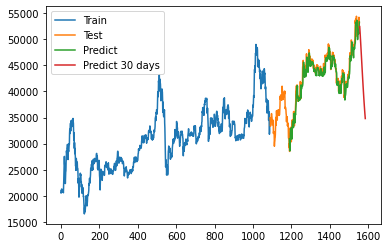

<Figure size 432x288 with 0 Axes>

In [13]:
GRU_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=30)

**BIDV 8:2 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Testing RMSE: 0.13373584581734474
Testing MAE: 0.016074545392673042
Testing MAPE: 13.828883055857496


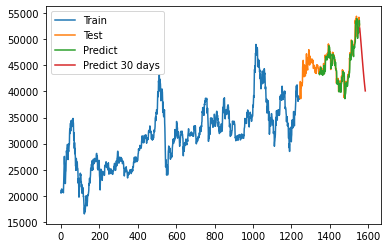

<Figure size 432x288 with 0 Axes>

In [14]:
GRU_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=30)

**BIDV 9:1 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Testing RMSE: 0.10813408544006718
Testing MAE: 0.02009044157149437
Testing MAPE: 9.99199487998149


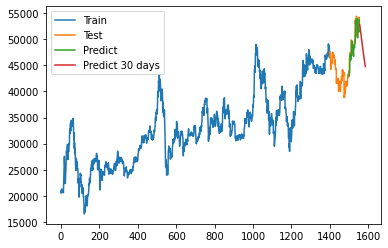

<Figure size 432x288 with 0 Axes>

In [15]:
GRU_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=30)

## **60 ngày**

**BIDV 7:3 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Testing RMSE: 0.17275073943938485
Testing MAE: 0.017417922957456627
Testing MAPE: 20.13567557470192


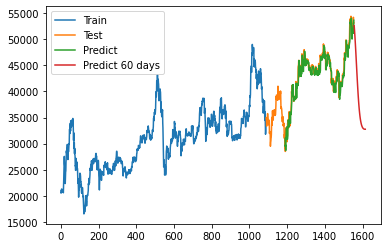

<Figure size 432x288 with 0 Axes>

In [16]:
GRU_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=60)

**BIDV 8:2 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Testing RMSE: 0.1332493417043536
Testing MAE: 0.017562597096614615
Testing MAPE: 13.75209769383038


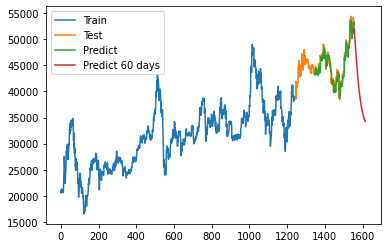

<Figure size 432x288 with 0 Axes>

In [17]:
GRU_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=60)

**BIDV 9:1 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Testing RMSE: 0.10844583044480408
Testing MAE: 0.01976775841843788
Testing MAPE: 10.1330772464917


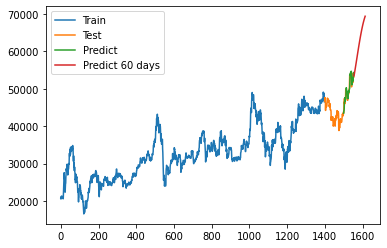

<Figure size 432x288 with 0 Axes>

In [18]:
GRU_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=60)

## **90 ngày**

**BIDV 7:3 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Testing RMSE: 0.17316531059204862
Testing MAE: 0.01649072669662917
Testing MAPE: 20.267452284502856


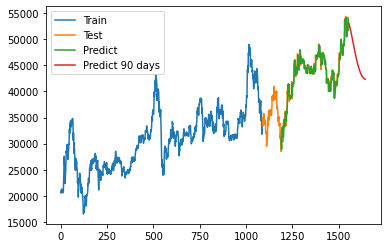

<Figure size 432x288 with 0 Axes>

In [19]:
GRU_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=90)

**BIDV 8:2 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Testing RMSE: 0.13377949757495464
Testing MAE: 0.01964779113141565
Testing MAPE: 13.77892676680351


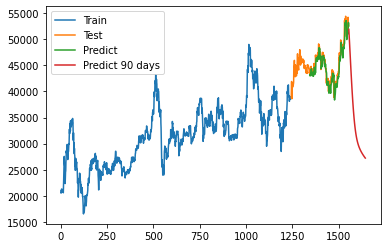

<Figure size 432x288 with 0 Axes>

In [20]:
GRU_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=90)

**BIDV 9:1 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Testing RMSE: 0.1081802660320199
Testing MAE: 0.019674613458985437
Testing MAPE: 10.013723492704491


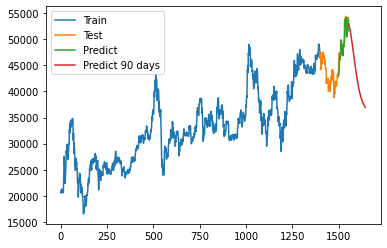

<Figure size 432x288 with 0 Axes>

In [21]:
GRU_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=90)

# **VCB**

## **30 ngày**

**VCB 7:3 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Testing RMSE: 0.15815021215098762
Testing MAE: 0.018378502718978066
Testing MAPE: 17.451476910949328


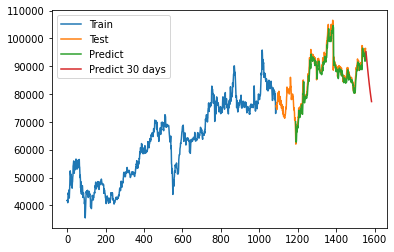

<Figure size 432x288 with 0 Axes>

In [22]:
GRU_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=30)

**VCB 8:2 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Testing RMSE: 0.11831143021111137
Testing MAE: 0.01638320010444643
Testing MAPE: 11.590231725222976


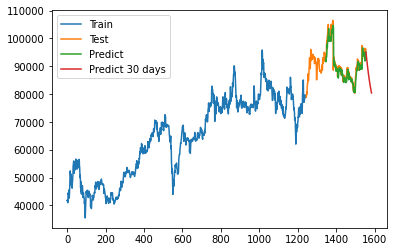

<Figure size 432x288 with 0 Axes>

In [23]:
GRU_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=30)

**VCB 9:1 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Testing RMSE: 0.06275456425828799
Testing MAE: 0.013382308279284886
Testing MAPE: 6.319328163134823


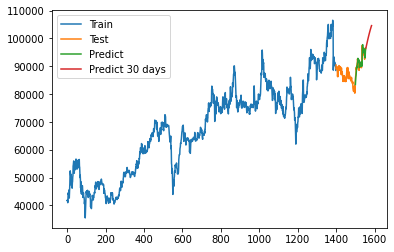

<Figure size 432x288 with 0 Axes>

In [24]:
GRU_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=30)

## **60 ngày**

**VCB 7:3 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Testing RMSE: 0.15823208433174205
Testing MAE: 0.015961190638245634
Testing MAPE: 17.51078044859217


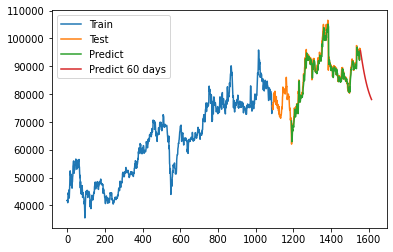

<Figure size 432x288 with 0 Axes>

In [25]:
GRU_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=60)

**VCB 8:2 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Testing RMSE: 0.11836541578289582
Testing MAE: 0.01658801699080333
Testing MAPE: 11.59233906571342


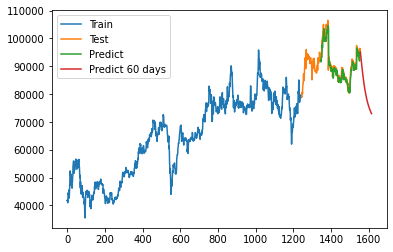

<Figure size 432x288 with 0 Axes>

In [26]:
GRU_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=60)

**VCB 9:1 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Testing RMSE: 0.06431546137466718
Testing MAE: 0.018232325131825825
Testing MAPE: 6.392819892561313


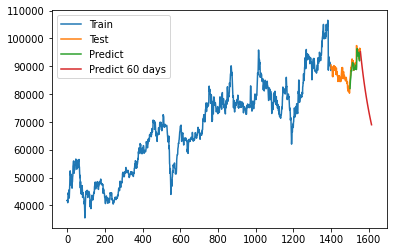

<Figure size 432x288 with 0 Axes>

In [27]:
GRU_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=60)

## **90 ngày**

**VCB 7:3 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Testing RMSE: 0.1576615464716473
Testing MAE: 0.01563477036625964
Testing MAPE: 17.472026248622814


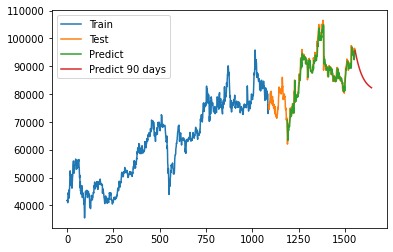

<Figure size 432x288 with 0 Axes>

In [28]:
GRU_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=90)

**VCB 8:2 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Testing RMSE: 0.11841355939486453
Testing MAE: 0.013660474252436609
Testing MAPE: 11.672679426170067


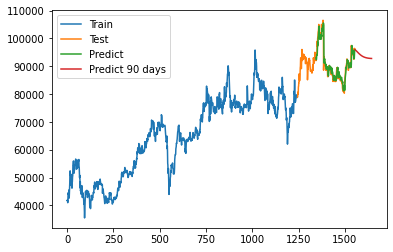

<Figure size 432x288 with 0 Axes>

In [29]:
GRU_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=90)

**VCB 9:1 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Testing RMSE: 0.06284649978426814
Testing MAE: 0.01355756572227125
Testing MAPE: 6.276962462297902


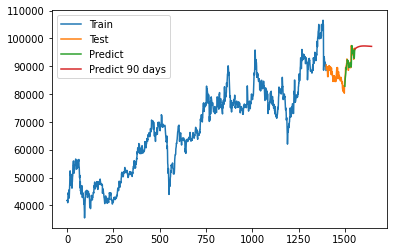

<Figure size 432x288 with 0 Axes>

In [30]:
GRU_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=90)

# **MBB**

## **30 ngày**

**MBB 7:3 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Testing RMSE: 0.12717652008785263
Testing MAE: 0.014251033301931013
Testing MAPE: 16.385864435630364


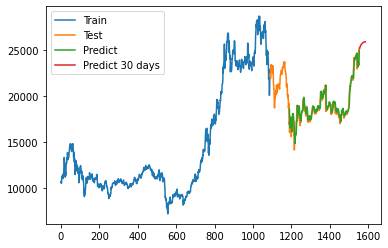

<Figure size 432x288 with 0 Axes>

In [31]:
GRU_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=30)

**MBB 8:2 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Testing RMSE: 0.1373779240689802
Testing MAE: 0.010848965497334074
Testing MAPE: 17.143719546819938


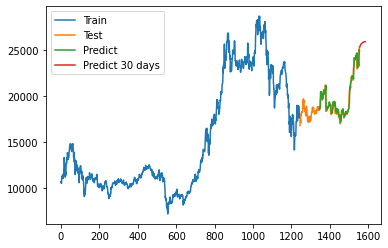

<Figure size 432x288 with 0 Axes>

In [32]:
GRU_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=30)

**MBB 9:1 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Testing RMSE: 0.09513518425526092
Testing MAE: 0.013449926339200469
Testing MAPE: 10.593041234257482


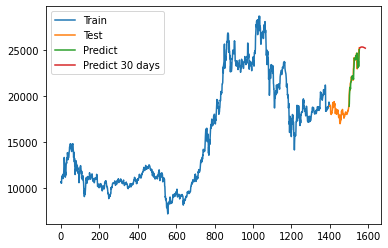

<Figure size 432x288 with 0 Axes>

In [33]:
GRU_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=30)

## **60 ngày**

**MBB 7:3 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Testing RMSE: 0.12744829957596576
Testing MAE: 0.01328792266705612
Testing MAPE: 16.400838679228542


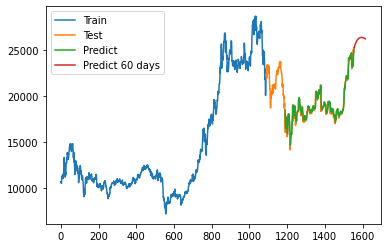

<Figure size 432x288 with 0 Axes>

In [34]:
GRU_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=60)

**MBB 8:2 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Testing RMSE: 0.13772068650252706
Testing MAE: 0.011752251974601596
Testing MAPE: 17.245892517895307


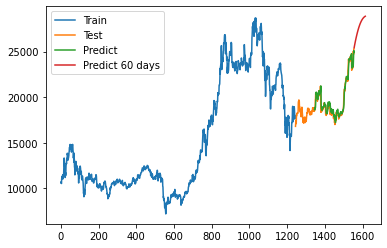

<Figure size 432x288 with 0 Axes>

In [35]:
GRU_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=60)

**MBB 9:1 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Testing RMSE: 0.09540210777072554
Testing MAE: 0.01496994140814164
Testing MAPE: 10.677391853045684


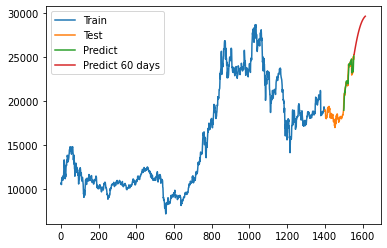

<Figure size 432x288 with 0 Axes>

In [36]:
GRU_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=60)

## **90 ngày**

**MBB 7:3 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Testing RMSE: 0.12744492343090652
Testing MAE: 0.014257078420257505
Testing MAPE: 16.43244768564685


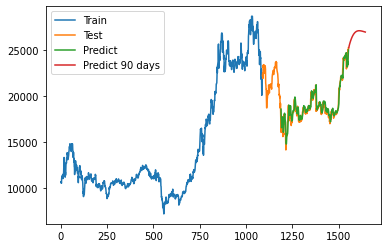

<Figure size 432x288 with 0 Axes>

In [37]:
GRU_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=90)

**MBB 8:2 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Testing RMSE: 0.13703776302492052
Testing MAE: 0.011017242230014955
Testing MAPE: 17.038110867070994


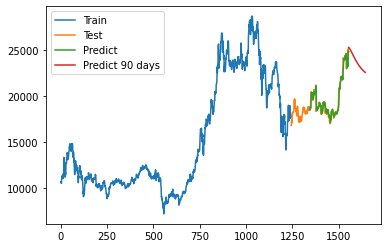

<Figure size 432x288 with 0 Axes>

In [38]:
GRU_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=90)

**MBB 9:1 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Testing RMSE: 0.09541910170758838
Testing MAE: 0.014185584404551262
Testing MAPE: 10.649282372768642


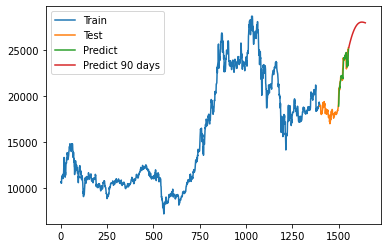

<Figure size 432x288 with 0 Axes>

In [39]:
GRU_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=90)